In [1]:
import numpy as np
import pandas as pd
from sqlalchemy import create_engine
import os
import jieba
import matplotlib.pyplot as plt


from keras.preprocessing.sequence import pad_sequences
from keras.preprocessing.text import one_hot, text_to_word_sequence, Tokenizer
from keras.models import Sequential
from keras.layers import Dense, Embedding, LSTM
from keras.callbacks import EarlyStopping,ModelCheckpoint
import keras.backend as K


Using TensorFlow backend.


In [2]:
# myQuery = '''
# SELECT * FROM pushs
# '''

# db_name = 'ptt_nba.db'
# path=os.path.join('..','crawler',db_name)
# url = 'sqlite:///%s'%(path)
# print(path)

# engine = create_engine(url)

# pushs = pd.read_sql_query(myQuery, engine)

def get_pushs():
    myQuery = '''
    SELECT * FROM pushs
    '''

    db_name = 'ptt_nba.db'
    path=os.path.join('..','crawler',db_name)
    url = 'sqlite:///%s'%(path)

    engine = create_engine(url)

    pushs = pd.read_sql_query(myQuery, engine)
    return pushs

pushs=get_pushs()
pushs.head()

,id,article_id,push,user,content,datetime
0,1,1560006190,推,RazaviSmith,我也覺得勇士會拿下G5,2019-06-08 23:03:00.000000
1,2,1560006190,推,KBmamba,我也覺得4-1結束太早,2019-06-08 23:03:00.000000
2,3,1560006190,推,bolide77,勇士已經五星可以上場了 磨合完就三連霸,2019-06-08 23:04:00.000000
3,4,1560006190,推,Fugacious,暴龍下場真的危險，聯盟會卯起來吹,2019-06-08 23:04:00.000000
4,5,1560006190,推,OGCOGCOGCOGC,頂多下場浪花爆發再偷到一勝吧 肯定沒G7~,2019-06-08 23:05:00.000000


In [3]:
def train_or_test(x):
    if x in ['推','噓']:
        return 'train'
    else:
        return 'test'

def get_push_value(x):
    if x == '推': return 1
    elif x == '噓': return 0
    else: return 'x'
    
    
# pushs['train_or_test'] = pushs['push'].apply(lambda x: train_or_test(x))
# pushs['push_value'] = pushs['push'].apply(lambda x: get_push_value(x))
# pushs = pushs[['train_or_test','content','push_value']]
# pushs

def process_pushs(pushs):
    pushs['train_or_test'] = pushs['push'].apply(lambda x: train_or_test(x))
    pushs['push_value'] = pushs['push'].apply(lambda x: get_push_value(x))
    pushs = pushs[['train_or_test','push_value','content']]
    return pushs

pushs_process=process_pushs(pushs)
pushs_process.head()

,train_or_test,push_value,content
0,train,1,我也覺得勇士會拿下G5
1,train,1,我也覺得4-1結束太早
2,train,1,勇士已經五星可以上場了 磨合完就三連霸
3,train,1,暴龍下場真的危險，聯盟會卯起來吹
4,train,1,頂多下場浪花爆發再偷到一勝吧 肯定沒G7~


In [4]:
# jieba_dit_path = os.path.join('.','dataset','dict.txt.big')
# jieba.set_dictionary(jieba_dit_path)

def set_jieba_dictionary():
    jieba_dit_path = os.path.join('.','dataset','dict.txt.big')
    jieba.set_dictionary(jieba_dit_path) 

set_jieba_dictionary()

In [5]:
# pushs['content_cut'] = pushs['content'].apply(lambda x: jieba.lcut(x))
# pushs['content_cut_join'] = pushs['content_cut'].apply(lambda x: ' '.join(x))
# pushs

def cut_content_by_jieba(pushs):
    pushs = pushs.copy()
    pushs['content_cut'] = pushs['content'].apply(lambda x: jieba.lcut(x))
    pushs['content_cut_join'] = pushs['content_cut'].apply(lambda x: ' '.join(x))
    return pushs

pushs_cut = cut_content_by_jieba(pushs_process)
pushs_cut.head()

Building prefix dict from /media/disk3/feynman52/See26/sentiment-classification/dataset/dict.txt.big ...
Loading model from cache /tmp/jieba.u787818dbf9c9ab0def30849470587ae4.cache
Loading model cost 1.834 seconds.
Prefix dict has been built succesfully.


,train_or_test,push_value,content,content_cut,content_cut_join
0,train,1,我也覺得勇士會拿下G5,"[我, 也, 覺得, 勇士, 會, 拿下, G5]",我 也 覺得 勇士 會 拿下 G5
1,train,1,我也覺得4-1結束太早,"[我, 也, 覺得, 4, -, 1, 結束, 太早]",我 也 覺得 4 - 1 結束 太早
2,train,1,勇士已經五星可以上場了 磨合完就三連霸,"[勇士, 已經, 五星, 可以, 上場, 了, , 磨合, 完, 就, 三連霸]",勇士 已經 五星 可以 上場 了 磨合 完 就 三連霸
3,train,1,暴龍下場真的危險，聯盟會卯起來吹,"[暴龍, 下場, 真的, 危險, ，, 聯盟, 會, 卯起來, 吹]",暴龍 下場 真的 危險 ， 聯盟 會 卯起來 吹
4,train,1,頂多下場浪花爆發再偷到一勝吧 肯定沒G7~,"[頂多, 下場, 浪花, 爆發, 再, 偷, 到, 一勝, 吧, , 肯定, 沒, G7, ~]",頂多 下場 浪花 爆發 再 偷 到 一勝 吧 肯定 沒 G7 ~


In [6]:
def get_pushs_all_train_test(pushs_cut):
    pushs_all=pushs_cut
    pushs_train=pushs_cut[pushs_cut.train_or_test=='train'].copy()
    pushs_test=pushs_cut[pushs_cut.train_or_test=='test'].copy()
    return pushs_all,pushs_train,pushs_test

pushs_all,pushs_train,pushs_test=get_pushs_all_train_test(pushs_cut)

In [7]:
# num_words = 20000
# tok = Tokenizer(num_words=num_words,
#                 filters='"!#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n',
#                 lower=True,
#                 split=' ', 
#                 char_level=False)

# tok.fit_on_texts(pushs_cut.content_cut_join)

def train_tokenizer(pushs_cut,num_words):
    tok = Tokenizer(num_words=num_words,
                    filters='"!#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n',
                    lower=True,
                    split=' ', 
                    char_level=False)

    tok.fit_on_texts(pushs_cut.content_cut_join)
    return tok

num_words = 20000
tok = train_tokenizer(pushs_all,num_words)

In [8]:
word_freq = pd.DataFrame({'word':list(tok.word_index.keys()),'freq':list(tok.word_index.values())})
word_freq = word_freq.sort_values(by='freq',ascending=False)
word_freq.head()


,word,freq
7329,要求,7330
7328,兩三個,7329
7327,我頭,7328
7326,苛刻,7327
7325,場把,7326


In [9]:
# x_train = tok.texts_to_sequences(pushs_cut.content_cut_join)
# maxlen = 50
# x_train = pad_sequences(x_train, maxlen=maxlen, padding='pre')
# x_train = np.array(x_train)
# x_train.shape
# x_train[0][-10:]

def get_xtrain_ytrain_xtest(pushs_train,pushs_test):
    maxlen = 50
    
    x_train = tok.texts_to_sequences(pushs_train.content_cut_join)
    x_train = pad_sequences(x_train, maxlen=maxlen, padding='pre')
    x_train = np.array(x_train)
    
    y_train = np.array(pushs_train.push_value)
    
    x_test = tok.texts_to_sequences(pushs_test.content_cut_join)
    x_test = pad_sequences(x_test, maxlen=maxlen, padding='pre')
    x_test = np.array(x_test)
    
    return x_train,y_train,x_test

x_train,y_train,x_test = get_xtrain_ytrain_xtest(pushs_train,pushs_test)
x_train.shape,y_train.shape,x_test.shape

((3353, 50), (3353,), (1859, 50))

In [10]:
# maxlen = 50
# sentences=['欠 噓','推']
# sentences=tok.texts_to_sequences(sentences)
# sentences=pad_sequences(sentences, maxlen=maxlen, padding='pre')
# sentences = np.array(sentences)
# sentences.shape

def get_sentences(sentences=['欠 噓','推']):
    maxlen = 50
    sentences=tok.texts_to_sequences(sentences)
    sentences=pad_sequences(sentences, maxlen=maxlen, padding='pre')
    sentences = np.array(sentences)
    return sentences

sentences=get_sentences(sentences=['欠 噓','推'])
sentences.shape

(2, 50)

In [11]:
print(pushs_train.content_cut_join[1])
print(x_train[1])
word_freq[word_freq.word.isin(pushs_train.content_cut_join[1].split(' '))] # G5 => g5


我 也 覺得 4 - 1 結束 太早
[  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0  11   8  62 114  70 196 509]


,word,freq
508,太早,509
195,結束,196
113,4,114
69,1,70
61,覺得,62
10,我,11
7,也,8


In [12]:
# # https://github.com/keras-team/keras/blob/master/keras/layers/embeddings.py

# # (3353, 50) => (3353, 50, 200000) => (3353, 50, 128) => (3353, 1)
# # (embedding                                        )            
# model = Sequential()
# model.add(Embedding(input_dim=num_words, output_dim=128))
# model.add(LSTM(128, dropout=0.5, recurrent_dropout=0.2))
# model.add(Dense(1, activation='sigmoid'))

# model.summary()

def get_model(num_words):
    model = Sequential()
    model.add(Embedding(input_dim=num_words, output_dim=128))
    model.add(LSTM(128, dropout=0.5, recurrent_dropout=0.2))
    model.add(Dense(1, activation='sigmoid'))
    model.summary()
    model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
    return model

model=get_model(num_words)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, None, 128)         2560000   
_________________________________________________________________
lstm_1 (LSTM)                (None, 128)               131584    
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 129       
Total params: 2,691,713
Trainable params: 2,691,713
Non-trainable params: 0
_________________________________________________________________


In [13]:
# early_stopping = EarlyStopping(monitor='val_acc', mode='max', verbose=1, patience=10, min_delta=0.001)

# batch_size=50
# epochs=100

# history = model.fit(x_train, y_train,
#                   batch_size=batch_size,
#                   epochs=epochs,
#                   validation_split=0.25,
#                     callbacks=[early_stopping])

def get_history_and_train_model():
    early_stopping = EarlyStopping(monitor='val_acc', mode='max', verbose=1, patience=10, min_delta=0.001)

    batch_size=50
    epochs=10

    history = model.fit(x_train, y_train,
                      batch_size=batch_size,
                      epochs=epochs,
                      validation_split=0.25,
                        callbacks=[early_stopping])
    
    return history

history=get_history_and_train_model()

Train on 2514 samples, validate on 839 samples
Epoch 1/10
2514/2514 [==============================] - 10s 4ms/step - loss: 0.4428 - acc: 0.8576 - val_loss: 0.4562 - val_acc: 0.8367
Epoch 2/10
2514/2514 [==============================] - 6s 2ms/step - loss: 0.3882 - acc: 0.8660 - val_loss: 0.4342 - val_acc: 0.8367
Epoch 3/10
2514/2514 [==============================] - 6s 2ms/step - loss: 0.3375 - acc: 0.8671 - val_loss: 0.3998 - val_acc: 0.8367
Epoch 4/10
2514/2514 [==============================] - 6s 3ms/step - loss: 0.2079 - acc: 0.9129 - val_loss: 0.5029 - val_acc: 0.8355
Epoch 5/10
2514/2514 [==============================] - 6s 3ms/step - loss: 0.1319 - acc: 0.9487 - val_loss: 0.4900 - val_acc: 0.8260
Epoch 6/10
2514/2514 [==============================] - 6s 3ms/step - loss: 0.0952 - acc: 0.9654 - val_loss: 0.5355 - val_acc: 0.8248
Epoch 7/10
2514/2514 [==============================] - 6s 2ms/step - loss: 0.0694 - acc: 0.9737 - val_loss: 0.6379 - val_acc: 0.8033
Epoch 8/10
251

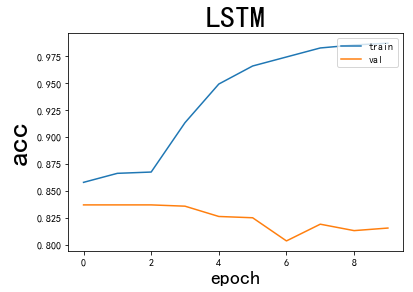

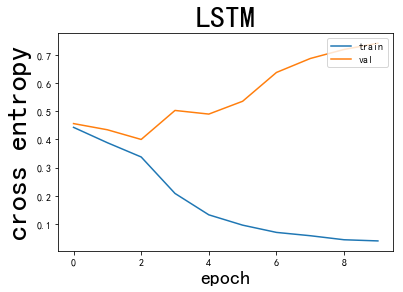

In [14]:
# plt.plot(history.history['acc'])
# plt.plot(history.history['val_acc'])
# plt.title('LSTM', fontsize=30)
# plt.ylabel('acc', fontsize=20)
# plt.xlabel('epoch', fontsize=20)
# plt.legend(['train', 'val'], loc='upper right')
# plt.show()

def plot_history(history):
    plt.plot(history.history['acc'])
    plt.plot(history.history['val_acc'])
    plt.title('LSTM', fontsize=30)
    plt.ylabel('acc', fontsize=30)
    plt.xlabel('epoch', fontsize=20)
    plt.legend(['train', 'val'], loc='upper right')
    plt.show()
    
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('LSTM', fontsize=30)
    plt.ylabel('cross entropy', fontsize=30)
    plt.xlabel('epoch', fontsize=20)
    plt.legend(['train', 'val'], loc='upper right')
    plt.show()
    
plot_history(history)

In [15]:
def get_predict_value(x_test):
    y_test=model.predict(x_test)
    return y_test

y_test=get_predict_value(x_test)
y_test.shape

(1859, 1)

In [16]:
# pushs_test['push_value2']=y_test
# pushs_test['push_value3']=pushs_test['push_value2'].apply(lambda x: int(round(x)))
# pushs_test

# pushs_train['push_value2']=pushs_train['push_value']
# pushs_train['push_value3']=pushs_train['push_value']
# pushs_train

# pushs_all_after_process = pushs_train.append(pushs_test)
# pushs_all_after_process = pushs_all_after_process.reset_index(drop=True)
# pushs_all_after_process

def get_pushs_all_after_process(pushs_train,pushs_test,y_test):
    pushs_test['push_value2']=y_test
    pushs_test['push_value3']=pushs_test['push_value2'].apply(lambda x: int(round(x)))
    pushs_train['push_value2']=pushs_train['push_value']
    pushs_train['push_value3']=pushs_train['push_value']
    pushs_all_after_process = pushs_train.append(pushs_test)
    pushs_all_after_process = pushs_all_after_process.reset_index(drop=True)
    return pushs_all_after_process
    
pushs_all_after_process=get_pushs_all_after_process(pushs_train,pushs_test,y_test)
pushs_all_after_process

,train_or_test,push_value,content,content_cut,content_cut_join,push_value2,push_value3
0,train,1,我也覺得勇士會拿下G5,"[我, 也, 覺得, 勇士, 會, 拿下, G5]",我 也 覺得 勇士 會 拿下 G5,1,1
1,train,1,我也覺得4-1結束太早,"[我, 也, 覺得, 4, -, 1, 結束, 太早]",我 也 覺得 4 - 1 結束 太早,1,1
2,train,1,勇士已經五星可以上場了 磨合完就三連霸,"[勇士, 已經, 五星, 可以, 上場, 了, , 磨合, 完, 就, 三連霸]",勇士 已經 五星 可以 上場 了 磨合 完 就 三連霸,1,1
3,train,1,暴龍下場真的危險，聯盟會卯起來吹,"[暴龍, 下場, 真的, 危險, ，, 聯盟, 會, 卯起來, 吹]",暴龍 下場 真的 危險 ， 聯盟 會 卯起來 吹,1,1
4,train,1,頂多下場浪花爆發再偷到一勝吧 肯定沒G7~,"[頂多, 下場, 浪花, 爆發, 再, 偷, 到, 一勝, 吧, , 肯定, 沒, G7, ~]",頂多 下場 浪花 爆發 再 偷 到 一勝 吧 肯定 沒 G7 ~,1,1
5,train,1,只要總冠沒G7打就好 勇士下去吧,"[只要, 總冠, 沒, G7, 打, 就, 好, , 勇士, 下去, 吧]",只要 總冠 沒 G7 打 就 好 勇士 下去 吧,1,1
6,train,1,"真的不需要擔心我勇, 浪花正常發揮就三連霸了","[真的, 不, 需要, 擔心, 我勇, ,, , 浪花, 正常, 發揮, 就, 三連霸, 了]","真的 不 需要 擔心 我勇 , 浪花 正常 發揮 就 三連霸 了",1,1
7,train,0,說暴龍放鬆戒心也太好笑,"[說, 暴龍, 放鬆, 戒心, 也, 太, 好笑]",說 暴龍 放鬆 戒心 也 太 好笑,0,0
8,train,1,"因為G6在灣區, 不管怎樣都會go home的 win or not","[因為, G6, 在, 灣區, ,, , 不管怎樣, 都, 會, go, , home,...","因為 G6 在 灣區 , 不管怎樣 都 會 go home 的 win or...",1,1
9,train,1,等志玲姐姐生孩子的時候 Curry的fmvp已經落選了,"[等志玲, 姐姐, 生, 孩子, 的, 時候, , Curry, 的, fmvp, 已經,...",等志玲 姐姐 生 孩子 的 時候 Curry 的 fmvp 已經 落選 了,1,1
